In [17]:
## Imports

import json
from matplotlib import pyplot as plt
import numpy as np
import os

from sklearn import linear_model as sklearn_linear_model


In [ ]:
# 2022-05-07:  np 30000.1452, v_probe

In [162]:
## Get paths to data

_BASE_SESSION_DIR = (
    '/Users/nicholaswatters/Desktop/grad_school/research/mehrdad/'
    'multi_prediction/phys/phys_data_test/Elgar/2022-10-13'
)
spike_sorting_dir = os.path.join(_BASE_SESSION_DIR, 'spike_sorting')
spike_sorting_v_probe_0_dir = os.path.join(spike_sorting_dir, 'v_probe_0')
spike_sorting_np_0_dir = os.path.join(spike_sorting_dir, 'np_0')

sync_dir = os.path.join(_BASE_SESSION_DIR, 'sync')
sync_mworks_dir = os.path.join(sync_dir, 'mworks')
sync_open_ephys_dir = os.path.join(sync_dir, 'open_ephys')
sync_spikeglx_dir = os.path.join(sync_dir, 'spikeglx')

In [163]:
## Get sync data

t_trial_start_mworks = [
    json.load(open(
        os.path.join(sync_mworks_dir, mw_session, 'trial_start_on_times'), 'r',
    ))
    for mw_session in os.listdir(sync_mworks_dir)
]
t_trial_start_open_ephys = np.genfromtxt(
    os.path.join(sync_open_ephys_dir, 'sync_trial_start_on.csv'))
t_trial_start_spikeglx = np.genfromtxt(
    os.path.join(sync_spikeglx_dir, 'sync_trial_start_on.csv'))

# Index first mworks trial
t_trial_start_mworks = np.array(t_trial_start_mworks[0])

# Print shapes
print(f'Mworks shape: {t_trial_start_mworks.shape}')
print(f'Open Ephys shape: {t_trial_start_open_ephys.shape}')
print(f'SpikeGLX shape: {t_trial_start_spikeglx.shape}')

Mworks shape: (2358,)
Open Ephys shape: (2357,)
SpikeGLX shape: (2357,)


In [164]:
def _timescale_transform(t_source, t_target, print_stats=False):
    if len(t_source) != len(t_target):
        raise ValueError(
            f'len(t_source) = {len(t_source)} but len(t_target) = '
            f'{len(t_target)}'
        )
    regr = sklearn_linear_model.LinearRegression()
    regr.fit(t_source[:, np.newaxis], t_target[:, np.newaxis])
    pred_t_target = regr.predict(t_source[:, np.newaxis])[:, 0]
    residuals = t_target - pred_t_target
    residual_std = np.round(1000. * np.std(residuals), decimals=1)
    residual_max_error = np.round(1000. * np.max(np.abs(residuals)), decimals=1)

    if print_stats:
        print(f'    residual_std: {residual_std} ms')
        print(f'    residual_max_error: {residual_max_error} ms')

    coef = regr.coef_[0]
    intercept = regr.intercept_

    return coef, intercept, residual_std


def _async_timescale_transform(t_source, t_target, print_stats=False):
    """Find relative offset and timescale transform between two timeseries.
    
    Args:
        t_source: Array of times. Typically trial start times for physiology.
        t_target: Array of times. Typically trial start times for mworks. Need
            not have the same length as t_source.
        print_stats: Bool. Whether to print statistics of the transform.
    """

    candidate_transforms = []
    for relative_start_index in range(-10, 10):
        if relative_start_index < 0:
            t_source = t_source[-1 * relative_start_index:]
        else:
            t_target = t_target[relative_start_index:]
        min_length = min(len(t_source), len(t_target))
        if min_length < 5:
            continue
        t_source = t_source[:min_length]
        t_target = t_target[:min_length]
        
        coef, intercept, residual_std = _timescale_transform(
            t_source, t_target, print_stats=print_stats)
        candidate_transforms.append(
            (relative_start_index, coef, intercept, residual_std)
        )
    
    residual_stds = np.array([x[3] for x in candidate_transforms])
    min_ind = np.argmin(residual_stds)
    min_residual_std = residual_stds[min_ind]
    if min_residual_std > 1.:
        raise ValueError(
            f'min_residual_std = {residual_stds[min_ind]}, which is too high'
        )
    relative_start_index, coef, intercept, _ = candidate_transforms[min_ind]

    return relative_start_index, coef, intercept


def _get_mworks_times


In [168]:
## Align timeseries to common clock

# Common clock is mworks timescale, starting at beginning of first trial
t_mworks_common = t_trial_start_mworks - t_trial_start_mworks[0]

# Open ephys must be regressed to mworks common clock
print('\nOpen Ephys temporal scaling:')
open_ephys_coef, open_ephys_intercept = _transform_to_common_clock(
    t_trial_start_open_ephys, t_mworks_common)

# Spikeglx must be regressed to mworks common clock
print('\nSpikeGLX temporal scaling:')
spikeglx_coef, spikeglx_intercept = _transform_to_common_clock(
    t_trial_start_spikeglx, t_mworks_common)


Open Ephys temporal scaling:
    residual_std: 0.1 ms
    residual_max_error: 0.4 ms

SpikeGLX temporal scaling:
    residual_std: 0.3 ms
    residual_max_error: 0.8 ms


In [169]:
## Load v_probe_0 spike times and apply open ephys temporal scaling to them

oe_start = 0.768
v_0_spike_times = np.squeeze(np.load(
    os.path.join(spike_sorting_v_probe_0_dir, 'spike_times.npy')))
v_0_spike_times = oe_start + v_0_spike_times / 30000.
v_0_spike_times_common = (
    open_ephys_intercept + open_ephys_coef * v_0_spike_times)
v_0_spike_clusters = np.squeeze(np.load(
    os.path.join(spike_sorting_v_probe_0_dir, 'spike_clusters.npy')))
v_0_cluster_ids = np.sort(np.unique(v_0_spike_clusters))

In [177]:
## Load np_0 spike times and apply open ephys temporal scaling to them

np_sample_rate = 30000.5
np_0_spike_times = np.squeeze(np.load(
    os.path.join(spike_sorting_np_0_dir, 'spike_times.npy')))
np_0_spike_times = np_0_spike_times / np_sample_rate
np_0_spike_times_common = (
    spikeglx_intercept + spikeglx_coef * np_0_spike_times)
np_0_spike_clusters = np.squeeze(np.load(
    os.path.join(spike_sorting_np_0_dir, 'spike_clusters.npy')))
np_0cluster_ids = np.sort(np.unique(v_0_spike_clusters))

In [178]:
## Plot rasters

_T_BEFORE_START_TIME = 0.5
_T_AFTER_START_TIME = 3.

def _plot_raster(spike_times, start_times, name=''):
    spikes_raster_x = []
    spikes_raster_y = []

    num_trials = len(start_times)
    spike_index = 0
    for trial_num in range(num_trials):
        start_t = start_times[trial_num]
        stimulus_onset_t = start_t

        # Update spikes raster data based on spike times
        next_trial = False
        while not next_trial:
            if spike_index >= len(spike_times):
                # No more spikes for this neuron, so move on to next trial
                next_trial = True
                continue
            
            spike_t = spike_times[spike_index]

            if spike_t > stimulus_onset_t + _T_AFTER_START_TIME:
                # Trial is completed, so move on to next trial
                next_trial = True
                continue
            
            if (trial_num < len(start_times) - 1 and
                    spike_t > start_times[trial_num + 1]):
                # Trial is completed, so move on to next trial
                next_trial = True
                continue

            if spike_t < stimulus_onset_t - _T_BEFORE_START_TIME:
                # Have yet to reach beginning of trial, so move on to next spike
                spike_index += 1
                continue

            # Append the spike time to raster data
            spikes_raster_x.append(spike_t - stimulus_onset_t)
            spikes_raster_y.append(trial_num)
            spike_index += 1
    
    # Make plot
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.scatter(spikes_raster_x, spikes_raster_y, c='k', s=0.1)
    ax.set_xlabel('Time within trial (sec)', fontsize=10)
    ax.set_ylabel('Trial number', fontsize=12)
    ax.set_xlim(
        -0.1 - _T_BEFORE_START_TIME,
        0.1 + _T_AFTER_START_TIME,
    )
    ax.set_ylim(-10, num_trials + 10)
    ax.set_title(name, fontsize=12, weight='bold', y=1.03)
    plt.show()
    

(121531,)


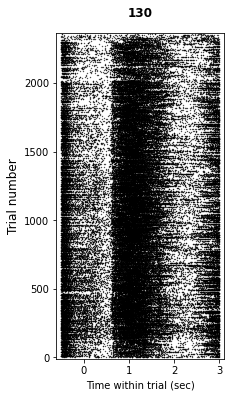

(57099,)


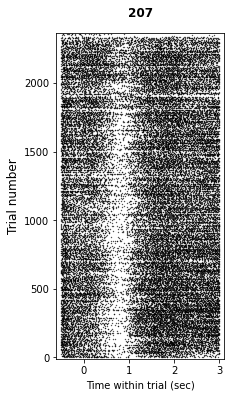

(154756,)


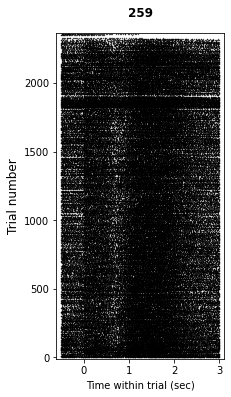

In [179]:
cluster_ids_to_plot = [130, 207, 259]

for id in cluster_ids_to_plot:
    cluster_spike_times = np_0_spike_times_common[np_0_spike_clusters == id]
    print(cluster_spike_times.shape)
    _plot_raster(cluster_spike_times, t_mworks_common, name=str(id))

(65254,)


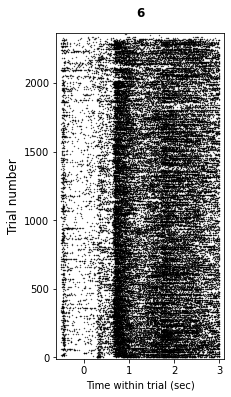

(44999,)


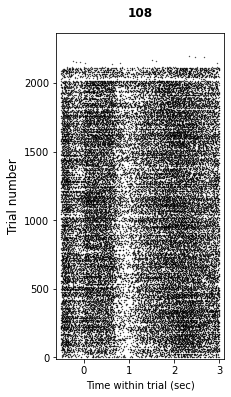

(85244,)


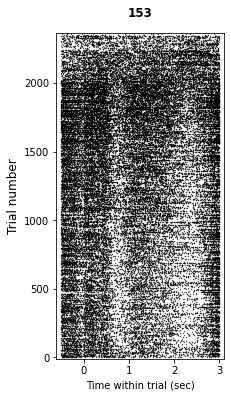

In [172]:
cluster_ids_to_plot = [6, 108, 153]

for id in cluster_ids_to_plot:
    cluster_spike_times = v_0_spike_times_common[v_0_spike_clusters == id]
    print(cluster_spike_times.shape)
    _plot_raster(cluster_spike_times, t_mworks_common, name=str(id))